**Напоминание:**
    
* Все ваши графики должны быть **"красивыми"** --- подробнее о том, как их оформлять, можно найти в первом практическом задании. При несоответствии какиму-то из критериев вам могут снять баллы.
* Пишите в текстовых ячейках/print в коде ответы на **все вопросы из заданий/просьбы сделать выводы** --- при их отсутствии мы не можем понять, сделали ли вы задание и понимаете, что происходит, и поэтому будем снижать баллы

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.54929897768199

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (1.5 баллa)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    all_preds = np.zeros((num_runs, X.shape[0])) 
    all_masks = np.zeros((num_runs, X.shape[0]))
    l = 0.0
    for i in range(num_runs):
        idx = np.random.randint(X.shape[0], size=X.shape[0])
        mask = np.ones(X.shape[0]) == 1
        mask[idx] = False

        regressor.fit(X[idx], y[idx])
        preds = regressor.predict(X[mask])
        l += ((preds - y[mask]) ** 2).mean()
        all_preds[i][mask] = preds
        all_masks[i][mask] = 1
    all_used = all_masks.sum(axis=0) > 0
    all_preds = all_preds[:, all_used]
    num_preds = all_masks[:, all_used].sum(axis=0)
    objects_mean = all_preds.sum(axis=0) / num_preds
    bias = ((objects_mean - y[all_used]) ** 2).mean()
    variance = ((all_preds ** 2).sum(axis=0) / (num_preds - 1) - (all_preds.sum(axis=0) ** 2) / (num_preds * (num_preds - 1))).mean()
    
    l = l / num_runs
    return bias, variance, l

**Задание 2. (0.5 баллa)**

**(0.3 балла)** Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
print('LinearRegression:')
bias, var, l = compute_biase_variance(LinearRegression(), X, y, 1000)
print('bias = %.4f, variance = %.4f, sum = %.4f, L = %.4f' % (bias, var, bias + var, l))
print('DecisionTree:')
bias, var, l = compute_biase_variance(DecisionTreeRegressor(), X, y, 1000)
print('bias = %.4f, variance = %.4f, sum = %.4f, L = %.4f' % (bias, var, bias + var, l))
print('RandomForest:')
bias, var, l = compute_biase_variance(RandomForestRegressor(), X, y, 1000)
print('bias = %.4f, variance = %.4f, sum = %.4f, L = %.4f' % (bias, var, bias + var, l))

LinearRegression:
bias = 23.7344, variance = 0.9390, sum = 24.6734, L = 24.5836
DecisionTree:
bias = 10.2442, variance = 13.1781, sum = 23.4223, L = 23.3311
RandomForest:
bias = 10.5593, variance = 2.2338, sum = 12.7931, L = 12.7696


**(0.1 балл) (?)** Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

По экспериментам видно, что ошибка приблизительно равна сумме смещения и разброса. Полученные результаты согласуются с теми, которые ожидалось получить. Линейная регрессия и решающее дерево имеют одинаковую ошибку, при этом у линейной регрессии большое смещение и маленький разброс, как у простой модели, а у решающего дерева разброс меньше и значительно больше разброс, так как деревья склонны к переобучению. Самая маленькая ошибка у случайного леса, так как алгоритм бэггинга уменьшает разброс по сравнению с решающим деревом и не меняет смещение.

**(0.1 балл) (?)** Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

Бутстрап уменьшает разброс базового алгоритма в количество раз, равное числу базовых алгоритмов. Так как в RandomForestRegressor число деревьев по умолчанию равно 100, разброс должен уменьшится в 100 раз, но в эксперименте он уменьшился чуть меньше, чем в 6 раз. Это может быть связано с тем, что базовые алгоритмы не независимые.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (1.5 балла)__

**(0.5 балла)** Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания для каждого из num_runs выборок. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом (в рамках каждого номера объекта, т.е. предсказания для объектов с одинаковым номером -- одинаковым цветом, а с разными -- разными цветами) все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    for i in range(num_runs):
        idx = np.random.randint(X_train.shape[0], size=X_train.shape[0])

        regressor.fit(X_train[idx], y_train[idx])
        preds = regressor.predict(X_test)
        plt.scatter(np.arange(num_test_objects), preds, c=[i for i in range(num_test_objects)], alpha=0.2, cmap='gist_rainbow')
        
    plt.title(title)
    plt.scatter(np.arange(num_test_objects), y_test, c='black', label=f'Правильный ответ')
    plt.xticks(np.arange(num_test_objects))
    plt.ylim([y_test.min() - 10, y_test.max() + 10])
    plt.xlabel('Номер тестового объекта', fontsize=10)
    plt.ylabel('Педсказания алгоритма', fontsize=10)

**(0.5 баллa)** Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

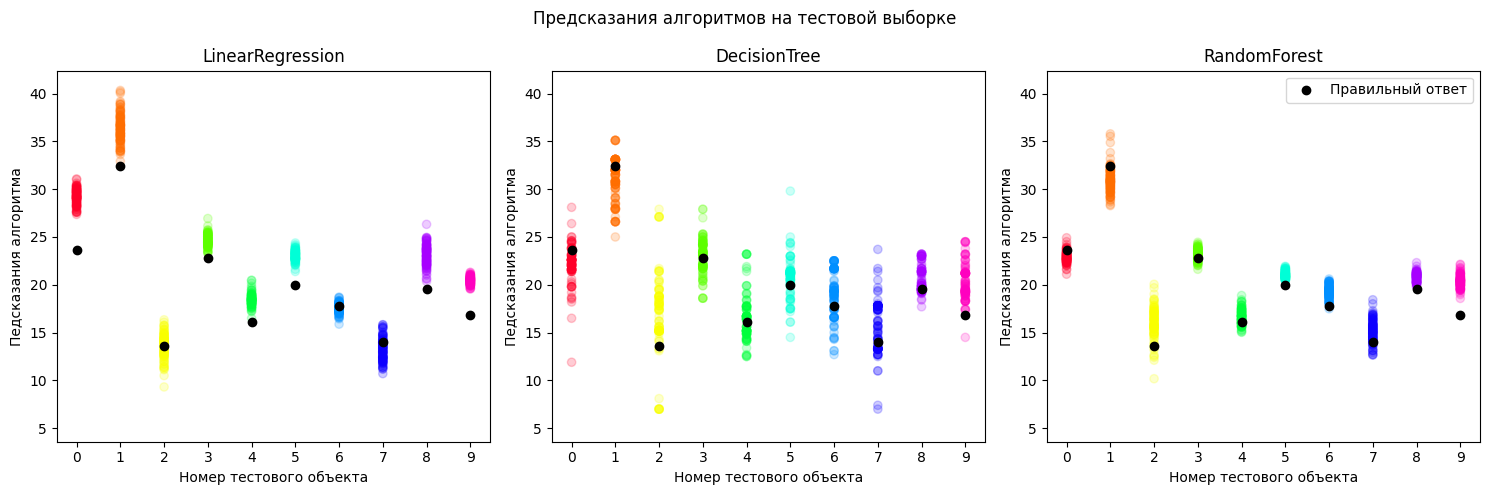

In [12]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('Предсказания алгоритмов на тестовой выборке', fontsize=12)

plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, num_runs=100, num_test_objects=10, title="LinearRegression")
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=100, num_test_objects=10, title="DecisionTree")
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, num_runs=100, num_test_objects=10, title="RandomForest")
plt.legend()

plt.tight_layout()
plt.show()

**(0.5 балла) (?)** Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

По графикам видно, что для линейной регрессии ответы модели имеют сильное смещение (находятся далеко от правильного ответа) и небольшой разброс (маленький диапазон значений). Решающее дерево имеет большой разброс значений, но меньшее смещение (черные точки находятся примерно посередине диапазона). Сдучайный лес значительно уменьшает разброс решающего дерева и не изменяет смещение (черные точки остаются примерно на том же расстоянии от середины диапазона)

### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869) если у вас нет аккаунта в kaggle, скачайте их [здесь](https://drive.google.com/drive/folders/1gU8yF0K9rtuRvdziMCcM5q8N5g7h2AVh?usp=sharing).
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы:
    * Воспользуйтесь описанием соревнования
    * При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [13]:
all_data = pd.read_csv('hse19-gbm/application_train.csv')
Y = all_data.TARGET.values
data = all_data.drop('TARGET', axis=1)
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


Задача состоит в предсказании целевой переменная(1 - клиент, испытывающий трудности с оплатой: он/она просрочил платеж более чем на X дней по крайней мере по одному из первых Y платежей по кредиту в нашей выборке, 0 - все остальные случаи)

Удалим столбец с идентификатором, так как он не несет полезной информации

In [14]:
data = data.drop('SK_ID_CURR', axis=1)

In [15]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

Определим численные и порядковые признаки

In [16]:
categorical = list(data.dtypes[data.dtypes == "object"].index)
num_features = list(data.dtypes[data.dtypes == "float64"].index)
other_features = list(data.dtypes[data.dtypes == "int64"].index)
len(categorical), len(num_features), len(other_features)

(16, 65, 39)

In [17]:
data[other_features].nunique()

CNT_CHILDREN                      14
DAYS_BIRTH                     17396
DAYS_EMPLOYED                  11792
DAYS_ID_PUBLISH                 6111
FLAG_MOBIL                         2
FLAG_EMP_PHONE                     2
FLAG_WORK_PHONE                    2
FLAG_CONT_MOBILE                   2
FLAG_PHONE                         2
FLAG_EMAIL                         2
REGION_RATING_CLIENT               3
REGION_RATING_CLIENT_W_CITY        3
HOUR_APPR_PROCESS_START           24
REG_REGION_NOT_LIVE_REGION         2
REG_REGION_NOT_WORK_REGION         2
LIVE_REGION_NOT_WORK_REGION        2
REG_CITY_NOT_LIVE_CITY             2
REG_CITY_NOT_WORK_CITY             2
LIVE_CITY_NOT_WORK_CITY            2
FLAG_DOCUMENT_2                    2
FLAG_DOCUMENT_3                    2
FLAG_DOCUMENT_4                    2
FLAG_DOCUMENT_5                    2
FLAG_DOCUMENT_6                    2
FLAG_DOCUMENT_7                    2
FLAG_DOCUMENT_8                    2
FLAG_DOCUMENT_9                    2
F

Признаки, для которых всего два значения (0 или 1), согласно описанию, это флаги, следовательно, их можно отнести к категориальным признакам. Признак времени так же можно отнести к категориальным, так как нельзя задать порядок. Признаки с 3 уникальными значениями характеризуют рейтинг, с 14 - количество, соответственно, их следует отнести к численным.

In [18]:
for f in other_features:
    if data[f].nunique() != 2 and f != 'HOUR_APPR_PROCESS_START':
        num_features.append(f)
        other_features.remove(f)
len(categorical), len(num_features), len(other_features)

(16, 68, 36)

In [19]:
data[other_features].var().sort_values()

FLAG_MOBIL                     4.645610e-06
FLAG_DOCUMENT_12               4.645610e-06
FLAG_DOCUMENT_10               1.858218e-05
FLAG_DOCUMENT_2                2.787301e-05
FLAG_DOCUMENT_4                7.432458e-05
FLAG_DOCUMENT_7                1.857907e-04
FLAG_DOCUMENT_17               2.508012e-04
FLAG_DOCUMENT_21               3.111604e-04
FLAG_DOCUMENT_20               4.689886e-04
FLAG_DOCUMENT_19               5.803667e-04
FLAG_DOCUMENT_15               1.155424e-03
FLAG_CONT_MOBILE               1.951986e-03
FLAG_DOCUMENT_14               2.913563e-03
FLAG_DOCUMENT_13               3.416721e-03
FLAG_DOCUMENT_9                3.882493e-03
FLAG_DOCUMENT_11               3.905539e-03
FLAG_DOCUMENT_18               7.995204e-03
FLAG_DOCUMENT_16               9.979393e-03
FLAG_DOCUMENT_5                1.494693e-02
REG_REGION_NOT_LIVE_REGION     1.510907e-02
LIVE_REGION_NOT_WORK_REGION    3.916760e-02
REG_REGION_NOT_WORK_REGION     4.848638e-02
FLAG_EMAIL                     5

Признаки FLAG_MOBIL, FLAG_CONT_MOBILE, и все FLAG_DOCUMENT имеют очень маленький разброс значений, большая часть обьектов принимает на них одинаковое значение. Эти признаки свидетельствуют о предоставлении документов и номера телефона и, вероятно, не несут в себе полезную информацию для модели. 

In [20]:
drop_columns = []
for f in other_features:
    if data[f].var() < 0.015:
        drop_columns.append(f)
        other_features.remove(f)
len(categorical), len(num_features), len(other_features)

(16, 68, 24)

In [21]:
data = data.drop(columns=drop_columns)

Рассмотрим количество пропусков в признаках и удалим те, в которых пропусков больше 60 процентов.

In [22]:
missing = (data.isnull().sum() / data.shape[0]).sort_values()
drop_columns = list(missing[missing > 0.6].index)
drop_columns

['OWN_CAR_AGE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'COMMONAREA_AVG']

In [23]:
for f in drop_columns:
    if f in num_features:
        num_features.remove(f)
    if f in categorical:
        categorical.remove(f)
    if f in other_features:
        other_features.remove(f)
data = data.drop(columns=drop_columns)
len(categorical), len(num_features), len(other_features)

(15, 52, 24)

In [24]:
data[categorical] = data[categorical].fillna("")
data[num_features] = data[num_features].fillna(data[num_features].mean())
data[other_features] = data[other_features].fillna(data[other_features].mode())
categorical = [*categorical, *other_features]

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, stratify=Y, random_state=0)

**Задание 5 (1 балл)**

**(0.7 баллa)** Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 

**(0.3 баллa) (?) Получилась ли заметная разнциа в качестве? Как вы думаете, почему?**

**Замечание:**
* В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [25]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score
import time

In [26]:
start_time = time.time()
clf = LGBMClassifier()
clf.fit(X_train[num_features], y_train)
y_pred = clf.predict_proba(X_test[num_features])[:, 1]
print('LightGBM:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))
start_time = time.time()
clf = CatBoostClassifier(logging_level='Silent')
clf.fit(X_train[num_features], y_train)
y_pred = clf.predict_proba(X_test[num_features])[:, 1]
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

LightGBM:
--- 4.1503 seconds ---
Test PR-AUC = 0.2223
Catboost:
--- 47.6491 seconds ---
Test PR-AUC = 0.2209


Качество алгоритмов примерно одинаково, LightGBM показал качество чуть выше, так же алгоритм CatBoost работает заметно дольше, что связано с оптимизациями внутри LightGBM для быстроты построения композиции.

__Задание 6. (2 балла)__

**(1.5 баллa)** Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;

Масштаб значений предлагается посмотреть [тут](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb).

**(0.5 баллa) (?)** Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 3**

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
start_time = time.time()
searcher = GridSearchCV(LGBMClassifier(),
                  param_grid={
                      'learning_rate': [0.001, 0.01, 0.1],
                      'max_depth': [3, 5, 7],
                      'n_estimators': [1, 5, 10, 100, 300, 500, 700]
                  },
                  cv=3,
                  scoring='average_precision', n_jobs=-1)
searcher.fit(X_train[num_features], y_train)
print('LightGBM:')
print("--- %.4f seconds ---" % (time.time() - start_time))
lightgbm_best_params = searcher.best_params_
print('best params:', lightgbm_best_params)
print('best score: %.4f' % searcher.best_score_)

LightGBM:
--- 805.8985 seconds ---
best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700}
best score: 0.2273


In [29]:
start_time = time.time()
searcher = GridSearchCV(CatBoostClassifier(logging_level='Silent'),
                  param_grid={
                      'learning_rate': [0.001, 0.1],
                      'max_depth': [3, 5, 7],
                      'n_estimators': [1, 10, 100, 400, 700],
                  },
                  cv=3,
                  scoring='average_precision', n_jobs=-1)
searcher.fit(X_train[num_features], y_train)
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
catboost_best_params = searcher.best_params_
print('best params:', catboost_best_params)
print('best score: %.4f' %  searcher.best_score_)

Catboost:
--- 657.2444 seconds ---
best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
best score: 0.2263


Оптимальное количество алгоритмов для Catboost меньше, чем для LightGBM, как и оптимальная глубина. Также у LightGBM темп обучения на один порядок меньше, чем у CatBoost. При этом LightGBM при оптимальных параметрах по качеству немного превосходит Catboost.

**Задание 7 (1.5 баллa)**

**(1 балл)** Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

**(0.5 баллa) (?)** Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('num', 'passthrough', num_features)
])

start_time = time.time()

X_train_ohe = column_transformer.fit_transform(X_train)
X_test_ohe = column_transformer.transform(X_test)
print('OneHotEncoder')
print("--- %.4f seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = LGBMClassifier()
clf.fit(X_train_ohe, y_train)
y_pred = clf.predict_proba(X_test_ohe)[:, 1]
print('LightGBM:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

start_time = time.time()
clf = CatBoostClassifier(logging_level='Silent')
clf.fit(X_train_ohe, y_train)
y_pred = clf.predict_proba(X_test_ohe)[:, 1]
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

OneHotEncoder
--- 3.0392 seconds ---
LightGBM:
--- 6.1627 seconds ---
Test PR-AUC = 0.2285
Catboost:
--- 117.8191 seconds ---
Test PR-AUC = 0.2258


In [31]:
from category_encoders import TargetEncoder

column_transformer = ColumnTransformer([
    ('ohe', TargetEncoder(), categorical),
    ('num', 'passthrough', num_features)
])

start_time = time.time()

X_train_te = column_transformer.fit_transform(X_train, y_train)
X_test_te = column_transformer.transform(X_test)
print('TargetEncoder')
print("--- %.4f seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = LGBMClassifier()
clf.fit(X_train_te, y_train)
y_pred = clf.predict_proba(X_test_te)[:, 1]
print('LightGBM:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

start_time = time.time()
clf = CatBoostClassifier(logging_level='Silent')
clf.fit(X_train_te, y_train)
y_pred = clf.predict_proba(X_test_te)[:, 1]
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

TargetEncoder
--- 5.9735 seconds ---
LightGBM:
--- 4.5259 seconds ---
Test PR-AUC = 0.2331
Catboost:
--- 66.0684 seconds ---
Test PR-AUC = 0.2340


Кодирование с использованием счетчиков со сглаживанием работает лучше, как по качеству, так и по времени. При использовании данного способа время обучения уменьшается почти в два раза для двух моделей.

**Задание 8 (1 балл)**

**(0.7 баллa)** Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта).  

**(0.3 баллa) (?)**Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [32]:
start_time = time.time()
clf = CatBoostClassifier(logging_level='Silent', cat_features=categorical, **catboost_best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print("Test PR-AUC = %.4f" % average_precision_score(y_test, y_pred))

Catboost:
--- 104.4835 seconds ---
Test PR-AUC = 0.2344


Время обучения значительно увеличилось в силу более сложной обработки категориальных признаков в CatBoost, однако качество незначительно выросло по сравнению с ручной обработкой

**Бонус. (1 балл)**

**(0.7 баллa)**Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. 

**(0.3 баллa) (?)**Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

In [33]:
column_transformer = ColumnTransformer([
    ('ohe', TargetEncoder(), categorical),
    ('num', 'passthrough', num_features)
])

X_train_te = column_transformer.fit_transform(X_train, y_train)

start_time = time.time()
searcher = GridSearchCV(LGBMClassifier(),
                  param_grid={
                      'max_depth': [3, 5, 7],
                      'n_estimators': [100, 300, 500, 700]
                  },
                  cv=3,
                  scoring='average_precision', n_jobs=-1)
searcher.fit(X_train_te, y_train)
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print('best params:', searcher.best_params_)
print('best score: %.4f' %  searcher.best_score_)

Catboost:
--- 598.8029 seconds ---
best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
best score: 0.2417


In [ ]:
start_time = time.time()
searcher = GridSearchCV(CatBoostClassifier(logging_level='Silent', cat_features=categorical),
                  param_grid={
                      'max_depth': [3, 5, 7],
                      'n_estimators': [100, 400, 700],
                  },
                  cv=3,
                  scoring='average_precision', n_jobs=-1)
searcher.fit(X_train, y_train)
print('Catboost:')
print("--- %.4f seconds ---" % (time.time() - start_time))
print('best params:', searcher.best_params_)
print('best score: %.4f' %  searcher.best_score_)

LightGBM показывает качество лучше, возможно, в силу большего числа значений параметров для подбора из-за скорости обучения
Catboost показывает качество лучше, так как лучше обрабатывает категориальные признаки, однако время его работы значительно дольше, что усложняет подбор гиперпараметров

**Бонус (0.2 балла)**

Ваш любимый новогодний фильм/сериал/мультик/книга/музыка/развление/ч-т-о-у-г-о-д-н-о

Всем мандаринок!&#127818;

Люблю мандарины, селедку под шубой и шампанское на новый год

А перед ним ходить на каток и в кино на что-нибудь русское и плохо снятое))